# Parameterizations

In this notebook, we'll review tools for defining, running, and comparing subgrid parameterizations.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)
import pyqg
import pyqg.diagnostic_tools
import matplotlib.pyplot as plt
%matplotlib inline

## Run baseline high- and low-resolution models

To illustrate the effect of parameterizations, we'll run two baseline models:

* a low-resolution model without parameterizations at `nx=64` resolution (where $\Delta x$ is larger than the deformation radius $r_d$, preventing the model from fully resolving eddies),

* a high-resolution model at `nx=256` resolution (where $\Delta x$ is ~4x finer than the deformation radius, so eddies can be almost fully resolved).

In [3]:
%%time
year = 24*60*60*360.
base_kwargs = dict(dt=3600., tmax=5*year, tavestart=2.5*year, twrite=25000)

low_res = pyqg.QGModel(nx=64, **base_kwargs)
low_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.28e-04, CFL: 0.059


CPU times: user 17.2 s, sys: 291 ms, total: 17.5 s
Wall time: 17.6 s


In [4]:
%%time
high_res = pyqg.QGModel(nx=256, **base_kwargs)
high_res.run()

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 7.42e-04, CFL: 0.241


CPU times: user 5min 29s, sys: 576 ms, total: 5min 29s
Wall time: 5min 34s


## Run Smagorinsky and backscatter parameterizations

Now we'll run two types of parameterization: one from [Smagorinsky 1963](https://doi.org/10.1175/1520-0493(1963)091%3C0099:GCEWTP%3E2.3.CO;2) which models an effective eddy viscosity from subgrid stress, and one adapted from [Jansen and Held 2014](https://doi.org/10.1016/j.ocemod.2014.06.002) and [Jansen et al. 2015](https://doi.org/10.1016/j.ocemod.2015.05.007), which reinjects a fraction of the energy dissipated by Smagorinsky back into larger scales:

In [5]:
def run_parameterized_model(p):
    model = pyqg.QGModel(nx=64, parameterization=p, **base_kwargs)
    model.run()
    return model

In [6]:
%%time
smagorinsky = run_parameterized_model(
    pyqg.parameterizations.Smagorinsky(constant=0.08))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 3.53e-04, CFL: 0.040


CPU times: user 48.7 s, sys: 312 ms, total: 49 s
Wall time: 49.3 s


In [7]:
%%time
backscatter = run_parameterized_model(
    pyqg.parameterizations.BackscatterBiharmonic(smag_constant=0.08, back_constant=1.1))

INFO:  Logger initialized
INFO: Step: 25000, Time: 9.00e+07, KE: 5.44e-04, CFL: 0.050


CPU times: user 47.9 s, sys: 331 ms, total: 48.2 s
Wall time: 48.5 s


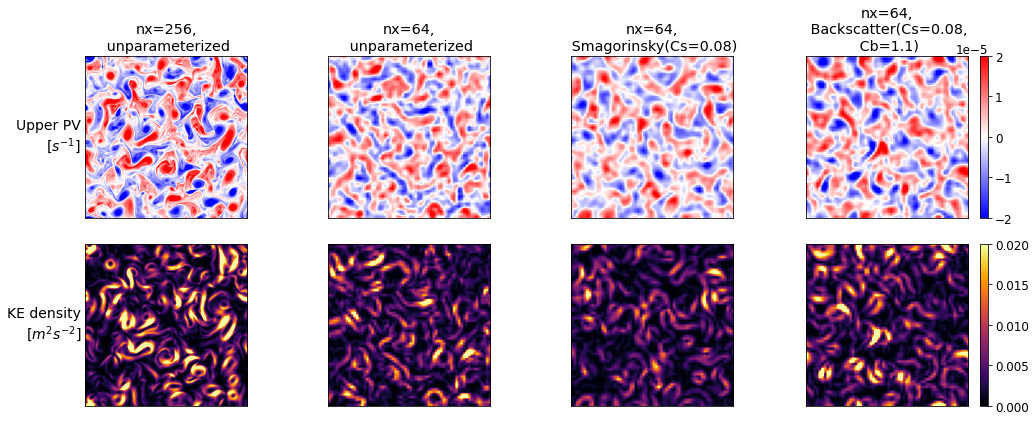

In [28]:
def label_for(sim):
    return f"nx={sim.nx}, {sim.parameterization or 'unparameterized'}"

plt.figure(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
vlim = 2e-5
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+1, title=label_for(sim).replace(',',",\n").replace('Biharmonic',''))
    plt.imshow(sim.q[0], vmin=-vlim, vmax=vlim, cmap='bwr')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("Upper PV\n[$s^{-1}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()
    
vlim = 2e-2
for i, sim in enumerate([high_res, low_res, smagorinsky, backscatter]):
    plt.subplot(2, 4, i+5)
    plt.imshow((sim.u**2 + sim.v**2).sum(0), vmin=0, vmax=vlim, cmap='inferno')
    plt.xticks([]); plt.yticks([])
    if i == 0: plt.ylabel("KE density\n[$m^2 s^{-2}$]", rotation=0, va='center', ha='right', fontsize=14)
    if i == 3: plt.colorbar()

plt.tight_layout()

Note how these are slightly slower than the baseline low-resolution model, but much faster than the high-resolution model.

See the parameterizations API section and code for examples of how these parameterizations are defined!

## Compute similarity metrics between parameterized and high-resolution simulations

To assist with evaluating the effects of parameterizations, we include helpers for computing similarity metrics between model diagnostics. Similarity metrics quantify the percentage closer a diagnostic is to high resolution than low resolution; values greater than 0 indicate improvement over low resolution (with 1 being the maximum), while values below 0 indicate worsening. We can compute these for all diagnostics for all four simulations:

In [8]:

sims = [high_res, backscatter, low_res, smagorinsky]

pd.DataFrame.from_dict([
    dict(Simulation=label_for(sim),
        **pyqg.diagnostic_tools.diagnostic_similarities(sim, high_res, low_res)) 
    for sim in sims])

,Simulation,Ensspec1,Ensspec2,KEspec1,KEspec2,...,ENSfrictionspec,APEgenspec,APEflux,KEflux,APEgen
0,"nx=256, unparameterized",1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000
1,"nx=64, BackscatterBiharmonic(Cs=0.08, Cb=1.1)",0.316093,0.232600,0.357153,0.477462,...,0.457135,0.343734,0.348660,0.488274,0.532484
2,"nx=64, unparameterized",0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000
3,"nx=64, Smagorinsky(Cs=0.08)",-0.420001,-0.188753,-0.460932,-0.412063,...,-0.417683,-0.138911,-0.466221,-0.248822,-0.311328


Note that the high-resolution and low-resolution models themselves have similarity scores of 1 and 0 by definition. In this case, the backscatter parameterization is consistently closer to high-resolution than low-resolution, while the Smagorinsky is consistently further.

Let's plot some of the actual curves underlying these metrics to get a better sense:

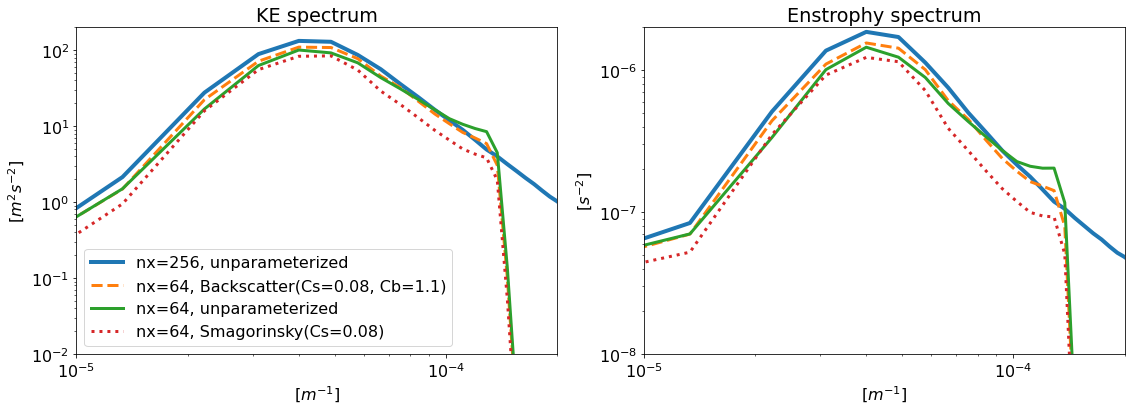

In [9]:
def plot_kwargs_for(sim):
    kw = dict(label=label_for(sim).replace('Biharmonic',''))
    kw['ls'] = (':' if sim.uv_parameterization else ('--' if sim.q_parameterization else '-'))
    kw['lw'] = (4 if sim.nx==256 else 3)
    return kw

plt.figure(figsize=(16,6))
plt.rcParams.update({'font.size': 16})

plt.subplot(121, title="KE spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('KEspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$m^2 s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-2,2e2)
plt.xlim(1e-5, 2e-4)
plt.legend(loc='lower left')

plt.subplot(122, title="Enstrophy spectrum")
for sim in sims:
    plt.loglog(
        *pyqg.diagnostic_tools.calc_ispec(sim, sim.get_diagnostic('Ensspec').sum(0)),
        **plot_kwargs_for(sim))
plt.ylabel("[$s^{-2}$]")
plt.xlabel("[$m^{-1}$]")
plt.ylim(1e-8,2e-6)
plt.xlim(1e-5, 2e-4)
plt.tight_layout()

The backscatter model, though low-resolution, has energy and enstrophy spectra that more closely resemble those of the high-resolution model.

In [14]:
def plot_spectra(m):
    m_ds = m.to_dataset().isel(time=-1)
    diag_names_enstrophy = ['ENSflux', 'ENSgenspec', 'ENSfrictionspec', 'ENSDissspec', 'ENSparamspec']
    diag_names_energy = ['APEflux', 'APEgenspec', 'KEflux', 'KEfrictionspec', 'Dissspec', 'paramspec']

    bud_labels_list = [['APE gen','APE flux','KE flux','Bottom drag','Diss.','Param.'], 
                       ['ENS gen','ENS flux','Dissipation','Friction','Param.']]
    title_list = ['Spectral Energy Transfer', 'Spectral Enstrophy Transfer']
    plt.figure(figsize = [15, 5])
    for p, diag_names in enumerate([diag_names_energy, diag_names_enstrophy]):
        bud = []
        for name in diag_names:
            kr, spec = pyqg.diagnostic_tools.calc_ispec(m, getattr(m_ds, name).data.squeeze())
            bud.append(spec.copy())
        plt.subplot(1, 2, p+1)
        [plt.semilogx(kr, term, label=label) for term, label in zip(bud, bud_labels_list[p])]
        plt.semilogx(kr, -np.vstack(bud).sum(axis=0), 'k--', label = 'Resid.')
        plt.legend(loc='best')
        plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
        plt.title(title_list[p])
    plt.tight_layout()

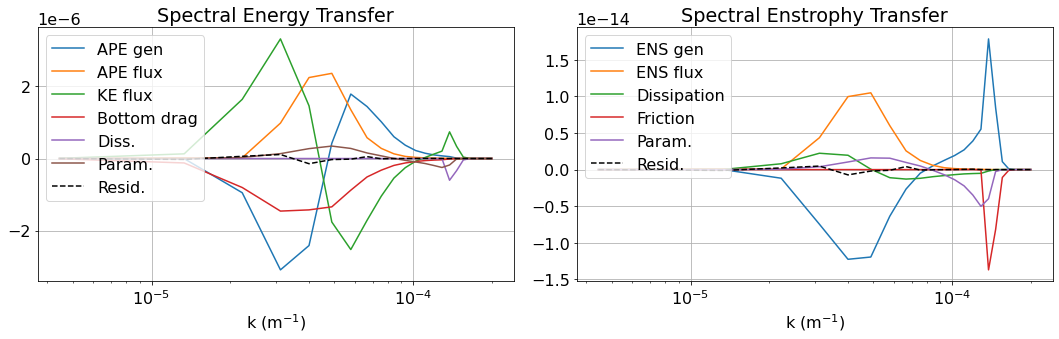

In [15]:
plot_spectra(backscatter)